# Reddit

In [106]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from string import ascii_letters, punctuation

ENG_STOPWORDS = stopwords.words('english')

locations = []
with open('locations.txt') as f:
    locations = [line.strip() for line in f.readlines()]

df = pd.read_csv('toilet_Reddit_output_test_02_11_2019.csv')

In [107]:
top_main_comment = df[['top_main_comment', 'timestamp']].apply(lambda x: [[y for y in x['top_main_comment'].split('\n') if y != '' and not y.startswith('=== Author: ')], x['timestamp']], axis=1)
orig_comments, timestamps = [], []
for comment in top_main_comment:
    orig_comments.extend(comment[0])
    timestamps.extend([comment[1]] * len(comment[0]))

In [108]:
comments = [x for x in orig_comments]
for i in range(len(comments)):
    comment = ''.join([ch.lower() for ch in comments[i] if ch in ascii_letters or ch == ' '])
    comment = ' '.join([word for word in comment.split() if word not in ENG_STOPWORDS])
    comments[i] = comment

In [109]:
def get_location(comment):
    for location in locations:
        if comment.find(location) != -1:
            return location
    return None

comments_df = pd.DataFrame(comments, columns=['Comment'])
comments_df['Original_Comment'] = orig_comments
comments_df['Timestamp'] = timestamps
comments_df['Location'] = comments_df.apply(lambda x: get_location(x['Comment']), axis=1)
print(len(comments_df))
comments_df.drop(comments_df.loc[comments_df['Comment'] == ''].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Comment'] == 'advertisement'].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.contains('1.0.1 |[Source code](https://github.com/fterh/sneakpeek) | [Contribute](https://github.com/fterh/sneakpeek)')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.contains('0.6.0-beta |[Source code](https://github.com/fterh/sneakpeek) | [Contribute](https://github.com/fterh/sneakpeek)')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.contains('0.5.0-beta |[Source code](https://github.com/fterh/sneakpeek) | [Contribute](https://github.com/fterh/sneakpeek)')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.startswith('[https://')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.startswith('v4.0 | [Github](https://github.com/fterh/rsg-retrivr) | [Readme/Changelog](https://github.com/fterh/rsg-retrivr/blob/master/README.md) | Summon me: `/u/rsg-retrivr summon`')].index, inplace=True)
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.startswith('> ')].index, inplace=True)  # drop quoted comments
comments_df.drop(comments_df.loc[comments_df['Original_Comment'].str.startswith('"> ')].index, inplace=True)  # drop quoted comments
print(len(comments_df))
filters = 'toilet,toilets,dirty,pee,shit,urine,poop,cleaner,smelly,disgusting,puking,urinal,cubicle,seat cover,paper,flush'.split(',')
comments_df.drop(comments_df.loc[~comments_df['Comment'].str.contains('|'.join(filters))].index, inplace=True)  # drop comments without the keywords
print(len(comments_df))
comments_df.reset_index(inplace=True)
comments_df.info()

5222
4636
947
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 5 columns):
index               947 non-null int64
Comment             947 non-null object
Original_Comment    947 non-null object
Timestamp           947 non-null object
Location            62 non-null object
dtypes: int64(1), object(4)
memory usage: 37.1+ KB


/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


In [4]:
# Import packages
import nltk
from pprint import pprint
import yaml
import sys
import os
import re

dict_tagged_sentences = ''
# Below indicates the relative path to
# positive/negative/inverter/incrementer/decrementer files
DICTIONARY_DIR_PREFIX = 'dicts2/'

class Splitter(object):
    def __init__(self):
        self.nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer()

    def split(self, text):
        """
        input format: a paragraph of text
        output format: a list of lists of words.
            e.g.: [['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'one']]
        """
        sentences = self.nltk_splitter.tokenize(text)
        tokenized_sentences = [self.nltk_tokenizer.tokenize(sent) for sent in sentences]
        return tokenized_sentences


class POSTagger(object):
    def __init__(self):
        pass

    def pos_tag(self, sentences):
        """
        input format: list of lists of words
            e.g.: [['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'one']]
        output format: list of lists of tagged tokens. Each tagged tokens has a
        form, a lemma, and a list of tags
            e.g: [[('this', 'this', ['DT']), ('is', 'be', ['VB']), ('a', 'a', ['DT']), ('sentence', 'sentence', ['NN'])],
                    [('this', 'this', ['DT']), ('is', 'be', ['VB']), ('another', 'another', ['DT']), ('one', 'one', ['CARD'])]]
        """

        pos = [nltk.pos_tag(sentence) for sentence in sentences]
        #adapt format
        pos = [[(word, word, [postag]) for (word, postag) in sentence] for sentence in pos]
        return pos

class DictionaryTagger(object):
    def __init__(self, dictionary_paths):
        """

        :rtype : object
        """
        files = [open(path, 'r') for path in dictionary_paths]
        dictionaries = [yaml.load(dict_file) for dict_file in files]
        map(lambda x: x.close(), files)
        self.dictionary = {}
        self.max_key_size = 0
        for curr_dict in dictionaries:
            for key in curr_dict:
                if key in self.dictionary:
                    self.dictionary[key].extend(curr_dict[key])
                else:
                    self.dictionary[key] = curr_dict[key]
                    self.max_key_size = max(self.max_key_size, len(key))

    def tag(self, postagged_sentences):
        return [self.tag_sentence(sentence) for sentence in postagged_sentences]

    def tag_sentence(self, sentence, tag_with_lemmas=False):
        """
        the result is only one tagging of all the possible ones.
        The resulting tagging is determined by these two priority rules:
            - longest matches have higher priority
            - search is made from left to right
        """
        tag_sentence = []
        N = len(sentence)
        if self.max_key_size == 0:
            self.max_key_size = N
        i = 0
        while (i < N):
            j = min(i + self.max_key_size, N) #avoid overflow
            tagged = False
            while (j > i):
                expression_form = ' '.join([word[0] for word in sentence[i:j]]).lower()
                expression_lemma = ' '.join([word[1] for word in sentence[i:j]]).lower()
                if tag_with_lemmas:
                    literal = expression_lemma
                else:
                    literal = expression_form
                if literal in self.dictionary:
                    #self.logger.debug("found: %s" % literal)
                    is_single_token = j - i == 1
                    original_position = i
                    i = j
                    taggings = [tag for tag in self.dictionary[literal]]
                    tagged_expression = (expression_form, expression_lemma, taggings)
                    if is_single_token: #if the tagged literal is a single token, conserve its previous taggings:
                        original_token_tagging = sentence[original_position][2]
                        tagged_expression[2].extend(original_token_tagging)
                    tag_sentence.append(tagged_expression)
                    tagged = True
                else:
                    j = j - 1
            if not tagged:
                tag_sentence.append(sentence[i])
                i += 1
        return tag_sentence

def value_of(sentiment):
    if sentiment == 'positive1': return 1
    if sentiment == 'positive2': return 2
    if sentiment == 'positive3': return 3
    if sentiment == 'negative1': return -1
    if sentiment == 'negative2': return -2
    if sentiment == 'negative3': return -3
    return 0

def sentiment_score(review):
    return sum ([value_of(tag) for sentence in dict_tagged_sentences for token in sentence for tag in token[2]])

def sentence_score(sentence_tokens, previous_token, acum_score):
    if not sentence_tokens:
        return acum_score
    else:
        current_token = sentence_tokens[0]
        tags = current_token[2]
        token_score = sum([value_of(tag) for tag in tags])
        if previous_token is not None:
            previous_tags = previous_token[2]
            if 'inc' in previous_tags:
                token_score *= 2.0
            elif 'dec' in previous_tags:
                token_score /= 2.0
            elif 'inv' in previous_tags:
                token_score *= -1.0
        return sentence_score(sentence_tokens[1:], current_token, acum_score + token_score)

def sentiment_score(sentences):
    return sum([sentence_score(sentence, None, 0.0) for sentence in sentences])


def run_analysis(text):
    splitter = Splitter() # This boy will split a long single string into sentences.
    postagger = POSTagger() # This boy is the Part-Of-Speech tagger.

    # If text contains multiple sentences, this line splits it into individual sentences.
    splitted_sentences = splitter.split(text)
    print (splitted_sentences)
    #exit(1)

    print ("########## This performs Part-Of-Speech tagging. ##########")
    # This performs Part-Of-Speech tagging.
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)
    #pprint (pos_tagged_sentences)
    #exit(1)

    print ("########## This line loads Positive word and Negative word corpus. ##########")
    # This line loads Positive word and Negative word dictionaries.
    dicttagger = DictionaryTagger([ DICTIONARY_DIR_PREFIX + 'positive.yml', DICTIONARY_DIR_PREFIX + 'negative.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    #pprint(dict_tagged_sentences)
    #exit(1)

    print ("########## [Baseline Analysis] Using only Positive/Negative corpus. ##########")
    score = sentiment_score(dict_tagged_sentences)
    print ("Score: %d" % score)
    #exit(1)

    print ("########## This line loads Positve/Negative corpus + incrementer/decrementer corpus. ##########")
    dicttagger = DictionaryTagger([ DICTIONARY_DIR_PREFIX + 'positive.yml', DICTIONARY_DIR_PREFIX + 'negative.yml', DICTIONARY_DIR_PREFIX + 'inc.yml', DICTIONARY_DIR_PREFIX + 'dec.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    #pprint(dict_tagged_sentences)
    score = sentiment_score(dict_tagged_sentences)
    print ("Score: %d" % score)
    #exit(1)

    print ("########## This line loads Positve/Negative corpus + incrementer/decrementer/inverter corpus. ##########")
    dicttagger = DictionaryTagger([ DICTIONARY_DIR_PREFIX + 'positive.yml', DICTIONARY_DIR_PREFIX + 'negative.yml', DICTIONARY_DIR_PREFIX + 'inc.yml', DICTIONARY_DIR_PREFIX + 'dec.yml', DICTIONARY_DIR_PREFIX + 'inv.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    #pprint(dict_tagged_sentences)
    score = sentiment_score(dict_tagged_sentences)
    print ("Score: %d" % score)
    #exit(1)
    
def run_my_analysis(text):
    splitter = Splitter() # This boy will split a long single string into sentences.
    postagger = POSTagger() # This boy is the Part-Of-Speech tagger.

    splitted_sentences = splitter.split(text)
    pos_tagged_sentences = postagger.pos_tag(splitted_sentences)

    dicttagger = DictionaryTagger([ DICTIONARY_DIR_PREFIX + 'positive.yml', DICTIONARY_DIR_PREFIX + 'negative.yml', DICTIONARY_DIR_PREFIX + 'inc.yml', DICTIONARY_DIR_PREFIX + 'dec.yml', DICTIONARY_DIR_PREFIX + 'inv.yml'])
    dict_tagged_sentences = dicttagger.tag(pos_tagged_sentences)
    return sentiment_score(dict_tagged_sentences)


In [111]:
# location,message,sentiment,sentiment score,date,source
# Bugis Junction,The toilet at Bugis Junction is horrible. It is not clean and there are poop stains on the toilet cover,Negative,-0.5,1/10/19,reddit
# EastPoint, Toilet so clean!!,Positive,1,1/9/18,reddit
# Pasir Ris MRT, Toilet stinks!,Negative,-0.1,1/8/20,reddit
# Bugis Junction,The toilet at Bugis Junction is so clean!!.Like Real,Negative,-0.5,1/9/19,reddit
# Katong,The toilet at Katong is so horrible,Negative,-0.5,1/9/19,reddit

import string
from textblob import TextBlob
from datetime import datetime
from nltk.tokenize import sent_tokenize, word_tokenize

def run_analysis(comment, source='Reddit'):
    date = datetime.now()
    message, date = comment['Comment'], datetime.strptime(comment['Timestamp'], '%Y-%m-%d %H:%M:%S')
    sentences = sent_tokenize(message)
    words = [word_tokenize(sentence) for sentence in sentences]
    words = [[word for word in word_sentence if word not in string.punctuation] \
             for word_sentence in words]

    location = comment['Location']
    sentiment = TextBlob(message).sentiment.polarity
    
    return (location if location is not None else 'NIL',
            comment['Original_Comment'],
            'Positive' if sentiment > 0 else 'Neutral' if sentiment == 0 else 'Negative',
            round(sentiment, 2),
            date.strftime('%d/%m/%Y'),
            source)

results = comments_df.apply(lambda x: run_analysis(x), axis=1)
results[:10]

0    (NIL, Yep. I always rate the highest whenever ...
1    (changi, Just give the excellent reviews to he...
2    (changi, Think Changi Airport has mentioned be...
3    (NIL, It is unfortunately not for kpi. More of...
4    (NIL, Actually, i don’t rate precisely because...
5    (NIL, Pretty sure the tablet is there to compl...
6    (NIL, I don't want to touch the thing, make my...
7    (NIL, Dad ever saw 2 young boys having fun pre...
8    (NIL, This reminds me of the complain thread t...
9    (NIL, On a frank note, cleaners don't clean ur...
dtype: object

In [112]:
sentiments = results.apply(pd.Series)
sentiments.columns = ('Location', 'Message', 'Sentiment', 'Sentiment Score', 'Date', 'Source')
sentiments
if True:
    with open('toilet_Reddit_sentiments.csv', 'w') as f:
        f.write(sentiments.to_csv(index=False))
sentiments

,Location,Message,Sentiment,Sentiment Score,Date,Source
0,NIL,Yep. I always rate the highest whenever i'm at...,Positive,0.37,17/10/2019,Reddit
1,changi,Just give the excellent reviews to help the fo...,Positive,0.15,17/10/2019,Reddit
2,changi,Think Changi Airport has mentioned before that...,Positive,0.19,17/10/2019,Reddit
3,NIL,It is unfortunately not for kpi. More of promp...,Negative,-0.60,17/10/2019,Reddit
4,NIL,"Actually, i don’t rate precisely because i jus...",Positive,0.20,17/10/2019,Reddit
5,NIL,Pretty sure the tablet is there to comply to s...,Positive,0.40,17/10/2019,Reddit
6,NIL,"I don't want to touch the thing, make my hand ...",Negative,-0.60,17/10/2019,Reddit
7,NIL,Dad ever saw 2 young boys having fun pressing ...,Positive,0.20,17/10/2019,Reddit
8,NIL,This reminds me of the complain thread the oth...,Positive,0.12,17/10/2019,Reddit
9,NIL,"On a frank note, cleaners don't clean urinals ...",Positive,0.18,17/10/2019,Reddit


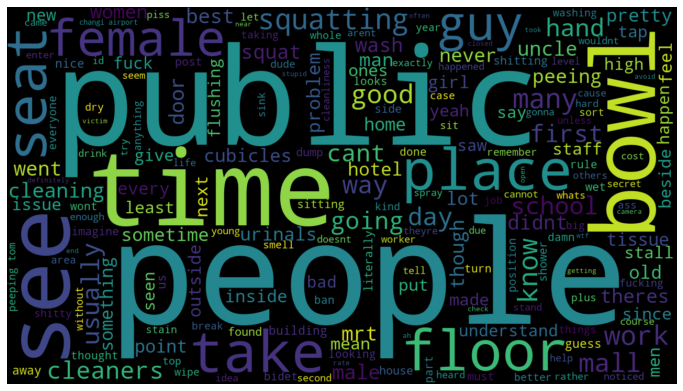

In [113]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import numpy as np

my_filters = list(filters) + ['one', 'like', 'actually', 'dont', 'would', 'lol', 'thats', 'probably', 'go', 'get', 'also',
                              'need', 'always', 'sure', 'really', 'even', 'thing', 'used', 'right', 'im', 'use', 'want',
                              'still', 'well', 'another', 'think', 'find', 'ive', 'using', 'someone', 'water', 'clean',
                              'singapore', 'back', 'got', 'make', 'maybe', 'look', 'come', 'might', 'yes', 'else',
                              'quite', 'little', 'youre', 'ever', 'two', 'sg', 'much', 'around', 'could']

wordlist = np.array(comments_df['Comment'], dtype=pd.Series)
wordlist = ' '.join(wordlist)
wordcloud = WordCloud(width=1280, height=720, stopwords=my_filters).generate(wordlist)
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

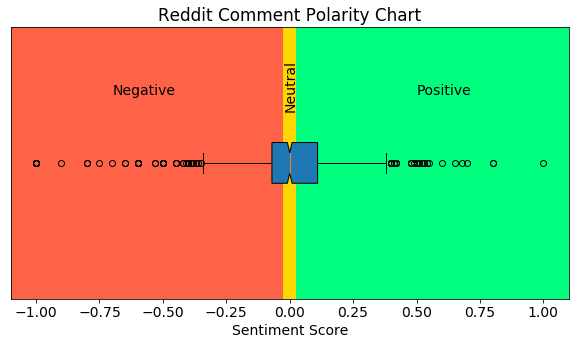

In [114]:
scores = sentiments['Sentiment Score']
orig_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = 14

plt.figure(figsize=(10, 5))
_ = plt.boxplot(scores, notch=True, patch_artist=True, vert=False)
left, right = plt.xlim()
plt.xlim(left, right)
plt.axvspan(left, 0, facecolor='tomato', zorder=-100)
plt.axvspan(-.025, 0.025, facecolor='gold', zorder=-100)
plt.axvspan(0.025, right, facecolor='springgreen', zorder=-100)

plt.annotate('Negative', xy=(-0.7, 1.25))
neutral_label = plt.annotate('Neutral', xy=(-.025, 1.2))
neutral_label.set_rotation(90)
plt.annotate('Positive', xy=(0.5, 1.25))

_ = plt.title('Reddit Comment Polarity Chart')
_ = plt.yticks([])
_ = plt.xlabel('Sentiment Score')
plt.show()
plt.rcParams['font.size'] = orig_font_size

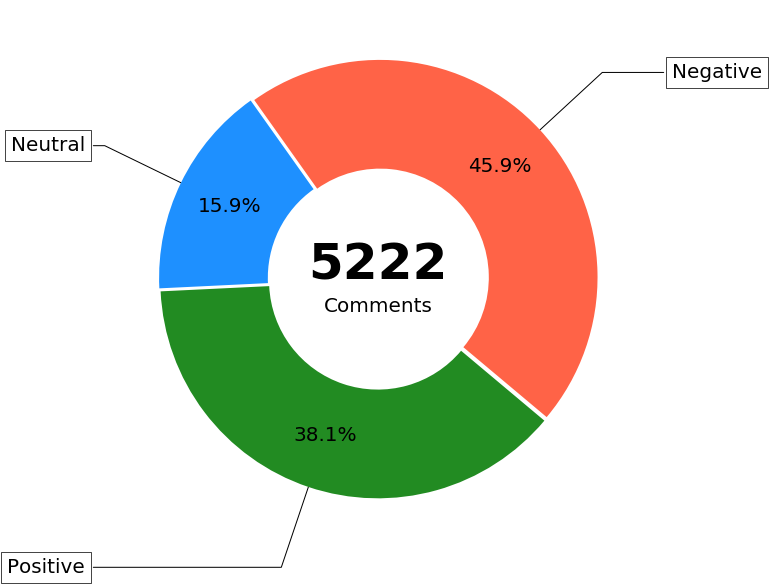

In [115]:
import matplotlib as mp

scores = sentiments['Sentiment Score']
orig_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = 20

positive, neutral, negative = 0, 0, 0
for score in scores:
    negative += score < 0
    neutral += score == 0
    positive += score > 0

# labels = ['Noise', 'Unrelated', 'Clean']
labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(10, 10))
wedges, plt_labels, texts = plt.pie([negative, neutral, positive], wedgeprops=dict(width=0.5), startangle=-40,
# wedges, plt_labels, texts = plt.pie([586, 3689, 947], wedgeprops=dict(width=0.5), startangle=-40,
                                     autopct='%1.1f%%', pctdistance=.75, explode=(.01, .01, .01),
                                     colors=('tomato', 'dodgerblue', 'forestgreen'))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)
# plt.annotate(str(len(scores)), xy=(-.325, 0), weight='bold', size=50)
plt.annotate('5222', xy=(-.325, 0), weight='bold', size=50)
plt.annotate('Comments', xy=(-.25, -.15))
plt.show()
plt.rcParams['font.size'] = orig_font_size

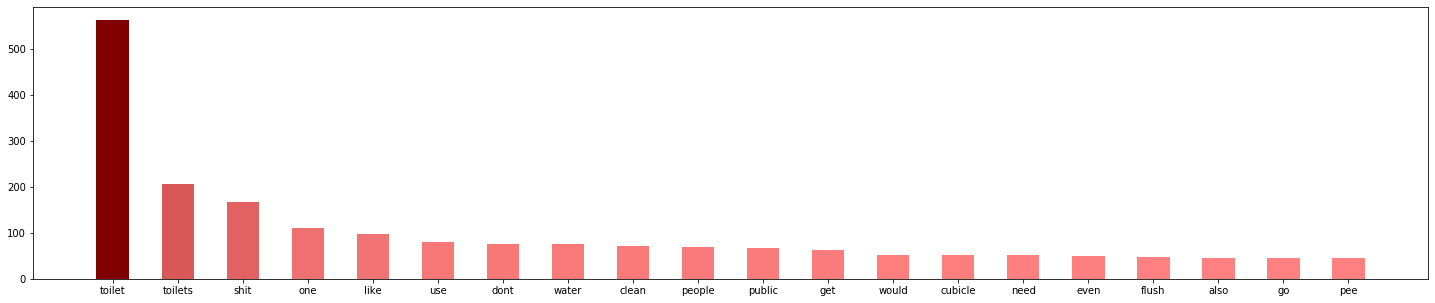

In [11]:
from collections import Counter
import matplotlib as mp

sanitized = comments_df['Comment']

counter = Counter(' '.join(sanitized).split())
top_words = sorted(dict(counter).items(), key=lambda x: x[1], reverse=True)
top_20_words = top_words[:20]
x_data = [x[0] for x in top_20_words]
y_data = [x[1] for x in top_20_words]

data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

plt.figure(figsize=(25, 5))
plt.bar(x_data, y_data, align='center', width=.5, color=color_map(data_normalizer(y_data)))
plt.show()

# TripAdvisor

In [1]:
import pickle
import json
import copy

print('reading file...')
lines = []
with open('tripadvisor.pkl', 'rb') as f:
    lines = pickle.load(f)

x_count = [0, 0, 0]
for i in range(len(lines)):
    line = lines[i]
    for j in range(len(line)):
        x_count[0] += len(line[j])
        line[j] = [sent for sent in line[j] if sent != '']
        line[j] = [sent for sent in line[j] if not sent.lower().startswith('thanks') \
                                    and 'dear ta expert' not in sent.lower() \
                                    and 'hello everyone' not in sent.lower() \
                                    and 'jj......' not in sent \
                                    and not sent.startswith('cheers') \
                                    and not sent.startswith('www.') \
                                    and not sent.startswith('http://') and not sent.startswith('https://') \
                                    and not 'Still waiting for a trip report' in sent \
                                    and not sent.startswith('tripadvisor.com')]
        x_count[1] += len(line[j])
        if '-:- Message from TripAdvisor staff -:-' in line[j]:
            index = line[j].index('-:- Message from TripAdvisor staff -:-')
            if index != -1:
                line[j] = line[j][:index]
        x_count[2] += len(line[j])

lines = [line for line in lines if len(line) > 0]
raw_lines = copy.deepcopy(lines)

total = 0
for line in lines:
    for comment in line:
        total += len(comment)
print(total)

print(json.dumps(lines, indent=4))

reading file...
223
[
    [
        [
            "We are a family planning to visit Singapore during last week of Sept 18. we have experience of using wet toilet only. Eg with Hand Faucet. While seeing the picks of Public Toilets, it seems all are dry toilets. i.e with Toilet rolls.",
            "Need your guidance if we can find Toilets with Hand Faucet in Singapore or we need start Practicing Toilet paper.",
            "You need to use toilet paper.",
            "Wow.",
            "First, there are requirements for a McDonalds nearby the hotel.",
            "Now, \"wet toilets.\"",
            "<<While seeing the picks of Public Toilets>>",
            "... LOL. Most people research 'Night Safari' or some such. But, no. You have researched toilets.",
            "Maybe you can find an instructional YouTube video to help you along with your \"practice\" ...",
            "I really don't see the point in mocking the OP",
            "Your post is completely unnecessary cccookie",

In [2]:
import string
from nltk.corpus import stopwords

ENG_STOPWORDS = stopwords.words('english')

for i in range(len(lines)):
    line = lines[i]
    for j in range(len(line)):
        comment = line[j]
        for k in range(len(comment)):
            comment[k] = ''.join([ch.lower() for ch in comment[k] if ch in string.ascii_letters or ch == ' '])
            comment[k] = ' '.join([word for word in comment[k].split() if word not in ENG_STOPWORDS])
            
print(json.dumps(lines, indent=4))
# text = ' '.join(lines)
# text = ''.join([ch.lower() for ch in text if ch in string.ascii_letters or ch == ' '])
# text = ' '.join([word for word in text.split() if word not in ENG_STOPWORDS])

[
    [
        [
            "family planning visit singapore last week sept experience using wet toilet eg hand faucet seeing picks public toilets seems dry toilets ie toilet rolls",
            "need guidance find toilets hand faucet singapore need start practicing toilet paper",
            "need use toilet paper",
            "wow",
            "first requirements mcdonalds nearby hotel",
            "wet toilets",
            "seeing picks public toilets",
            "lol people research night safari researched toilets",
            "maybe find instructional youtube video help along practice",
            "really dont see point mocking op",
            "post completely unnecessary cccookie",
            "washrooms singapore dry may able get cubicle hand faucet far mosques places wet washrooms",
            "actually think might missing point op making jaynewcastle",
            "seriously think op requires practice particular feat possibly practiced newborn say suspect used hose

In [100]:
print(x_count)
# 432 noise
# 32 tripadvisor staff line
# 223 clean

[687, 255, 223]


In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

filters = 'toilet,toilets,dirty,pee,shit,urine,poop,cleaner,smelly,disgusting,puking,urinal,cubicle,seat cover,paper,flush'.split(',')
my_filters = list(filters) + ['one', 'like', 'actually', 'dont', 'would', 'lol', 'thats', 'probably', 'go', 'get', 'also',
                              'need', 'always', 'sure', 'really', 'even', 'thing', 'used', 'right', 'im', 'use', 'want',
                              'still', 'well', 'another', 'think', 'find', 'ive', 'using', 'someone', 'water', 'clean',
                              'singapore', 'back', 'got', 'make', 'maybe', 'look', 'come', 'might', 'yes', 'else',
                              'quite', 'little', 'youre', 'ever', 'two', 'sg', 'much', 'around', 'could', 'hi', 'know', 
                              'etc', 'malaysia', 'may', 'op', 'thank', 'malacca', 'people', 'place', 'thread']

text = []
for line in lines:
    for comment in line:
        for sent in comment:
            text.append(sent)
text = ' '.join(text)

wordcloud = WordCloud(width=1280, height=720, stopwords=my_filters).generate(text)
plt.figure(figsize=(14, 14))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

<Figure size 1400x1400 with 1 Axes>

In [5]:
import string
from textblob import TextBlob
from datetime import datetime
from nltk.tokenize import sent_tokenize, word_tokenize

def run_analysis(comment, source='Reddit'):
    date = datetime.now()
    message, date = comment, None # datetime.strptime(comment['Timestamp'], '%Y-%m-%d %H:%M:%S')
    sentences = sent_tokenize(message)
    words = [word_tokenize(sentence) for sentence in sentences]
    words = [[word for word in word_sentence if word not in string.punctuation] \
             for word_sentence in words]

    location = None #  comment['Location']
    sentiment = TextBlob(message).sentiment.polarity
    
    return comment, \
           'Positive' if sentiment > 0 else 'Neutral' if sentiment == 0 else 'Negative', \
           round(sentiment, 2)

results = []
for i, line in enumerate(lines):
    for j, comment in enumerate(line):
        for k, sent in enumerate(comment):
            results.append([raw_lines[i][j][k], run_my_analysis(sent)])
results[:10]

with open('tripadvisor_sentiments.txt', 'w') as f:
    for i, result in enumerate(results):
        f.write(f"{result[0]},{result[1]}")
        f.write('\n')

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


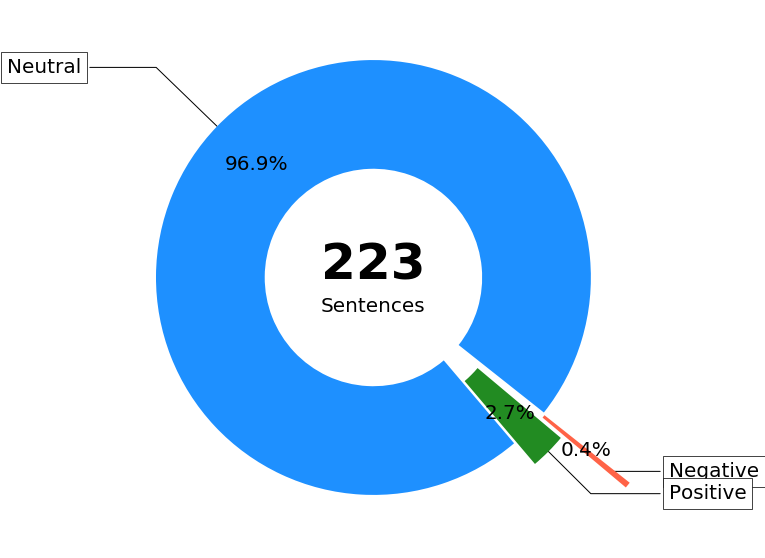

In [91]:
import matplotlib as mp
import numpy as np

scores = np.array(results)[:, 1].astype('float')
orig_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = 20

positive, neutral, negative = 0, 0, 0
for score in scores:
    negative += score < 0
    neutral += score == 0
    positive += score > 0

labels = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(10, 10))
wedges, plt_labels, texts = plt.pie([negative, neutral, positive], wedgeprops=dict(width=0.5), startangle=-40,
                                     autopct='%1.1f%%', pctdistance=.75, explode=(.5, .01, .125),
                                     colors=('tomato', 'dodgerblue', 'forestgreen'))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)
plt.annotate(str(len(scores)), xy=(-.25, 0), weight='bold', size=50)
plt.annotate('Sentences', xy=(-.25, -.15))
plt.show()
plt.rcParams['font.size'] = orig_font_size

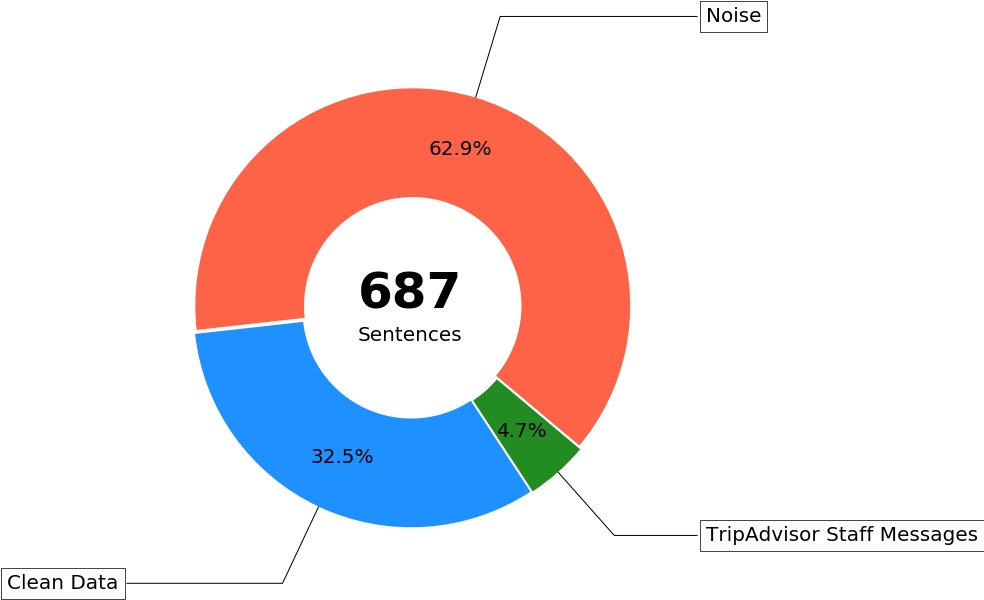

In [104]:
import matplotlib as mp
import numpy as np

scores = np.array(results)[:, 1].astype('float')
orig_font_size = plt.rcParams['font.size']
plt.rcParams['font.size'] = 20

labels = ['Noise', 'Clean Data', 'TripAdvisor Staff Messages']
plt.figure(figsize=(10, 10))
wedges, plt_labels, texts = plt.pie([432, 223, 32], wedgeprops=dict(width=0.5), startangle=-40,
                                     autopct='%1.1f%%', pctdistance=.75, explode=(.01, .01, .01),
                                     colors=('tomato', 'dodgerblue', 'forestgreen'))

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    plt.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)
plt.annotate(str(sum([432, 223, 32])), xy=(-.25, 0), weight='bold', size=50)
plt.annotate('Sentences', xy=(-.25, -.15))
plt.show()
plt.rcParams['font.size'] = orig_font_size